In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''

import argparse

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.emnist_lines import EMNISTLines, construct_image_from_string, get_samples_by_char
from text_recognizer.data.sentence_generator import SentenceGenerator

## Synthetic Dataset

We can put together EMNIST characters into sequences.
The sequences will be drawn from a natural language corpus.

Let's start by just drawing 8 characters at a time, with no overlap between the letters.

In [2]:
sentence_generator = SentenceGenerator()
for _ in range(4):
    print(sentence_generator.generate(max_length=16))

its maturity
influence of
in nontime It
livres with


In [3]:
args = argparse.Namespace(max_length=8, min_overlap=0, max_overlap=0)
dataset = EMNISTLines(args)
dataset.prepare_data()
dataset.setup()
print(dataset)
print('Mapping:', dataset.mapping)

EMNISTLinesDataset generating data for train...
EMNISTLinesDataset generating data for val...
EMNISTLinesDataset generating data for test...
EMNISTLinesDataset loading data from HDF5...


/home/sergeyk/miniconda3/envs/fsdl-text-recognizer-2021/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


EMNIST Lines Dataset
Min overlap: 0
Max overlap: 0
Num classes: 83
Dims: (1, 56, 1024)
Output dims: (89, 1)
Train/val/test sizes: 10000, 2000, 2000
Batch x stats: (torch.Size([128, 1, 56, 1024]), torch.float32, tensor(0.), tensor(0.0036), tensor(0.0456), tensor(0.9957))
Batch y stats: (torch.Size([128, 89]), torch.int64, tensor(1), tensor(66))

Mapping: ['<B>', '<S>', '<E>', '<P>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?']


In [4]:
def convert_y_label_to_string(y, dataset=dataset):
    return ''.join([dataset.mapping[i] for i in y if i != 3])

y_example = dataset.data_train[0][1]
print(y_example, y_example.shape)
convert_y_label_to_string(y_example)

[ 1 55 47 40 58 44  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3] (89,)


'<S>phase<E>'

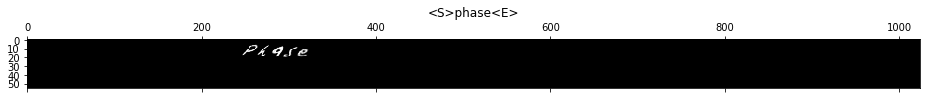

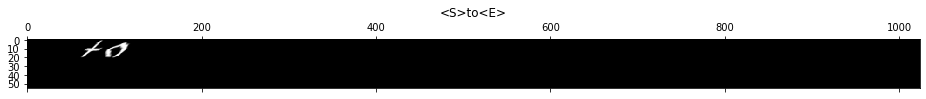

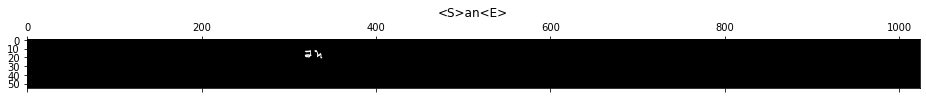

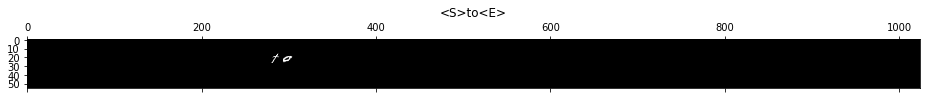

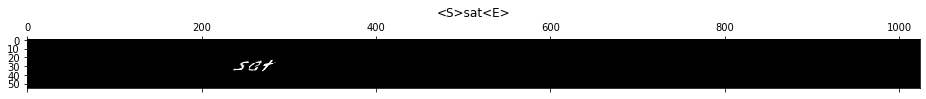

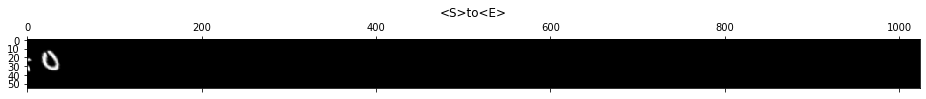

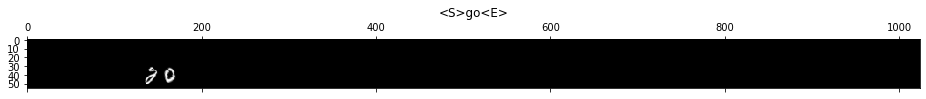

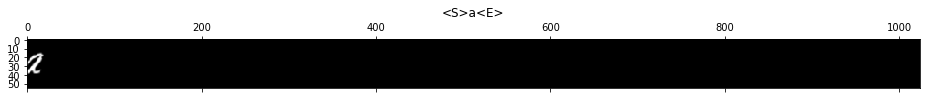

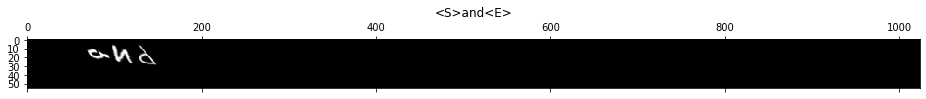

In [5]:
num_samples_to_plot = 9

for i in range(num_samples_to_plot):
    x, y = dataset.data_train[i]
    sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray')
    plt.title(sentence)

## Making it more difficult

Let's now expand the maximum number of characters in a line, and add a random amount of overlap between the letters.

EMNISTLinesDataset loading data from HDF5...
EMNIST Lines Dataset
Min overlap: 0.2
Max overlap: 0.5
Num classes: 83
Dims: (1, 56, 1024)
Output dims: (89, 1)
Train/val/test sizes: 10000, 2000, 2000
Batch x stats: (torch.Size([128, 1, 56, 1024]), torch.float32, tensor(0.), tensor(0.0178), tensor(0.1008), tensor(0.9963))
Batch y stats: (torch.Size([128, 89]), torch.int64, tensor(1), tensor(66))



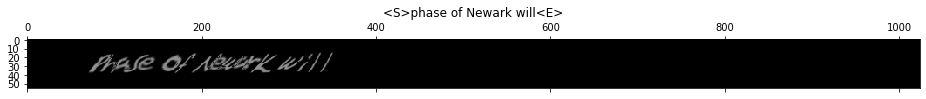

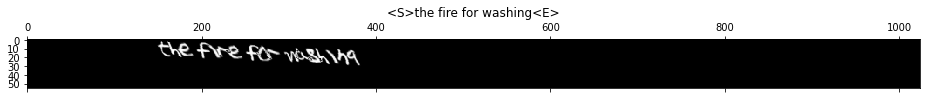

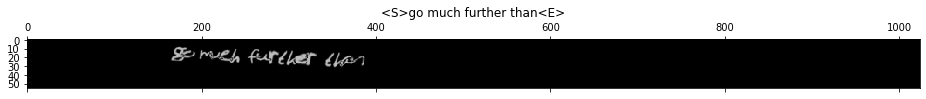

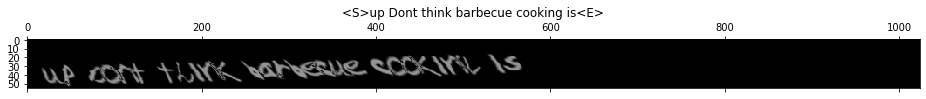

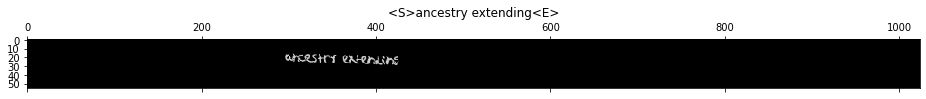

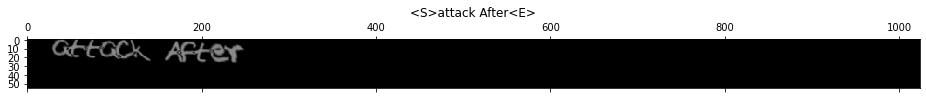

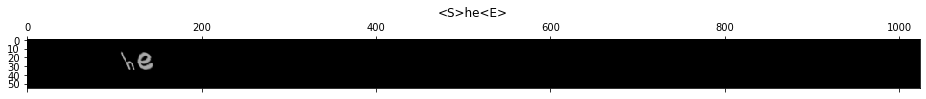

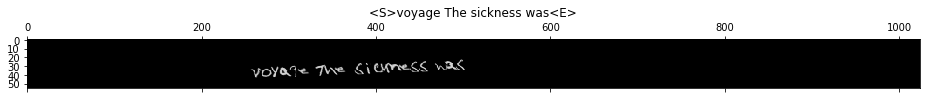

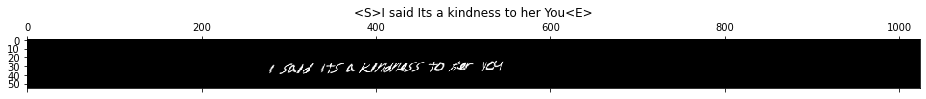

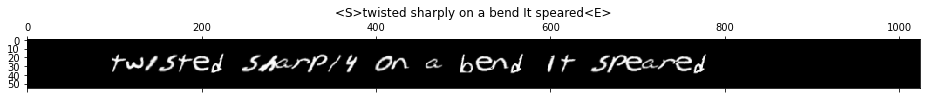

In [6]:
args = argparse.Namespace(min_overlap=0.2, max_overlap=0.5, max_length=43)
dataset = EMNISTLines(args)
dataset.prepare_data()
dataset.setup()
print(dataset)

for i in range(10):
    x, y = dataset.data_train[i]
    sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(sentence)

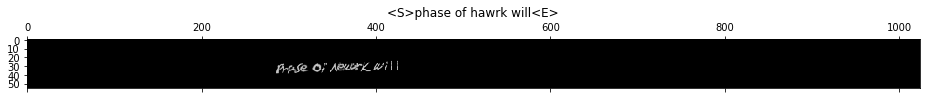

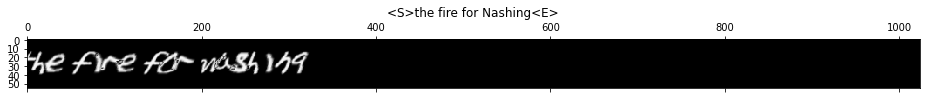

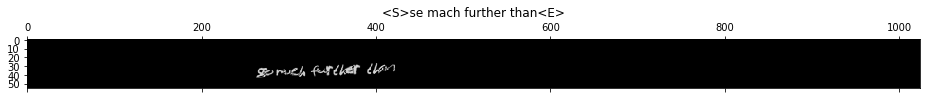

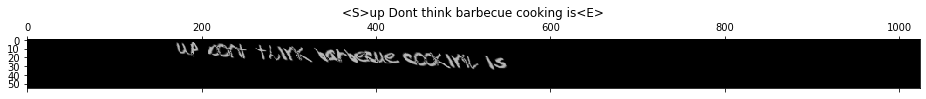

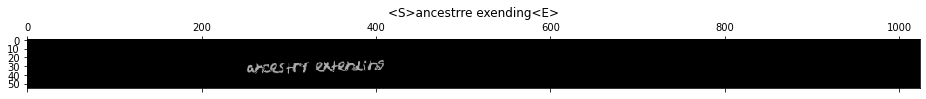

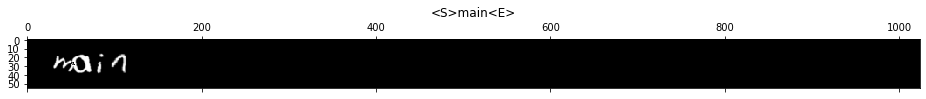

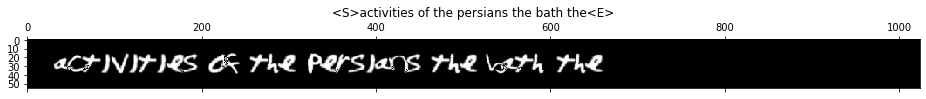

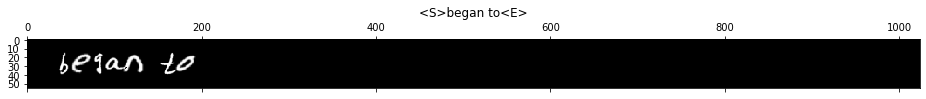

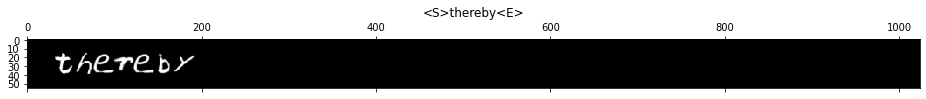

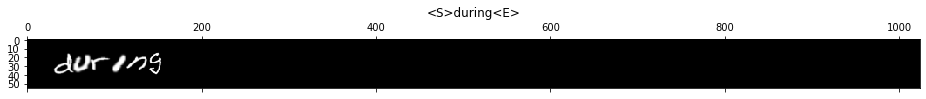

In [7]:
import argparse
from text_recognizer.lit_models import TransformerLitModel
from text_recognizer.models import LineCNNTransformer

model = LineCNNTransformer(
    data_config=dataset.config(),
    args=argparse.Namespace()
)
lit_model = TransformerLitModel.load_from_checkpoint(
    '../training/logs/default_fsdl-text-recognizer-2021-training/469_3ocpqryn/checkpoints/epoch=125-step=5039.ckpt',
    model=model,
    args=argparse.Namespace()
)

for i in range(5):
    x, y = dataset.data_train[i]
    pred = lit_model(x.unsqueeze(0))
    pred_sentence = ''.join(dataset.mapping[_] for _ in pred[0].tolist() if _ != 3)
    true_sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(pred_sentence)
    
for i in range(5):
    x, y = dataset.data_test[i]
    pred = lit_model(x.unsqueeze(0))
    pred_sentence = ''.join(dataset.mapping[_] for _ in pred[0].tolist() if _ != 3)
    true_sentence = convert_y_label_to_string(y) 
    plt.matshow(x.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(pred_sentence)